# SNOTEL exploratory visualization notebook
---
*J. Michelle Hu  
University of Utah  
December 2024*  


In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
import seaborn as sns

from pathlib import PurePath

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

# Set seaborn palette
sns.set_palette('magma')

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# Locate pyproj_datadir for studio env
# From https://stackoverflow.com/questions/69630630/on-fresh-conda-installation-of-pyproj-pyproj-unable-to-set-database-path-pypr
CONDA_ENV = 'studio'
miniconda_dir = '/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3'
proj_version = h.fn_list(miniconda_dir, f'envs/{CONDA_ENV}/conda-meta/proj-[0-9]*.json')[0]

VERSION = PurePath(proj_version).stem
pyprojdatadir = f'{miniconda_dir}/pkgs/{VERSION}/share/proj'
print(pyprojdatadir)
pyproj.datadir.set_data_dir(pyprojdatadir)

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-h54d7996_1/share/proj


# Snow depth time series

Use metloom to plot a time series of snow depth (and other variables) for designated basin and time period

In [4]:
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts'

# SNOTEL all sites geojson fn - snotel site json
allsites_fn = '/uufs/chpc.utah.edu/common/home/skiles-group3/ancillary_sdswe_products/SNOTEL/snotel_sites_32613.json'

WY_list = [2021, 2022, 2023, 2024]

In [9]:
def get_basin_snotel_ts(basin, WY, allsites_fn, script_dir):
    """ Get SNOTEL data for a basin for a given time period"""

    # Figure out filenames of polygons for the basin
    poly_fn = h.fn_list(script_dir, f'*{basin}*setup/polys/*shp')[0]
    print(poly_fn)

    # Locate SNOTEL sites within basin
    found_sites = proc.locate_snotel_in_poly(poly_fn=poly_fn, site_locs_fn=allsites_fn,
                                            buffer=200
                                            )

    # Get site names and site numbers
    sitenames = found_sites['site_name']
    sitenums = found_sites['site_num']
    print(sitenames)

    ST_arr = ['CO'] * len(sitenums)
    gdf_metloom, snotel_dfs, snotel_metadf = proc.get_snotel(sitenums, sitenames,
                                                            ST_arr,
                                                            WY=WY,
                                                            return_meta=True)
    return gdf_metloom, snotel_dfs, snotel_metadf

def prep_basin_snotel_ts(snotel_dfs):
    # Concatenate all snotel dataframes from dict into a single dataframe
    big_snoteldf = pd.concat(snotel_dfs, axis=1)
    # Fix multiindex so that site number is appended to individual columns
    big_snoteldf.columns = big_snoteldf.columns.map('{0[0]}_{0[1]}'.format)
    # big_snoteldf.head()

    # Prep xtick positions/labels for plotting
    # Select indices for Oct 1
    oct1 = big_snoteldf.index[(big_snoteldf.index.month == 10) & (big_snoteldf.index.day == 1)]
    # Do the same for April 1
    apr1 =  big_snoteldf.index[(big_snoteldf.index.month == 4) & (big_snoteldf.index.day == 1)]
    # Combine  DateTimeIndices into a single variable
    combined = np.concatenate([oct1, apr1])
    # combined

    # Pull only the snow depth columns (in meters) and create a new dataframe
    snowdepth_cols = [f for f in big_snoteldf.columns if '_SNOWDEPTH_m' in f]
    snotel_megadf = big_snoteldf[snowdepth_cols]

    return snotel_megadf, snowdepth_cols, combined

def plot_indiv_basin_snotel_ts(basin, snotel_megadf, snowdepth_cols, combined, colors=None):
    # Plot the snow depth for all the SNOTEL sites in this basin
    _, ax = plt.subplots(figsize=(16, 3))
    snotel_megadf.plot(ax=ax, linewidth=1, linestyle='-', color=colors, alpha=0.7)
    colnames = [f.split('_')[0] for f in snowdepth_cols]
    ax.legend(loc='center', bbox_to_anchor=(1, 1.3), labels=colnames);
    # set xticks for indices of choice (Oct 1 and Apr 1)
    ax.set_xticks(combined)
    ax.set_ylabel('Snow Depth (m)');
    ax.set_xlabel('Date');
    ax.grid(True)
    ax.set_title(f'{basin}')

/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/blue_river_setup/polys/blue_river_basin_outline_HUC10dissolved_32613.shp
155    Copper Mountain (415)
167       Fremont Pass (485)
170       Grizzly Peak (505)
173       Hoosier Pass (531)
Name: site_name, dtype: object


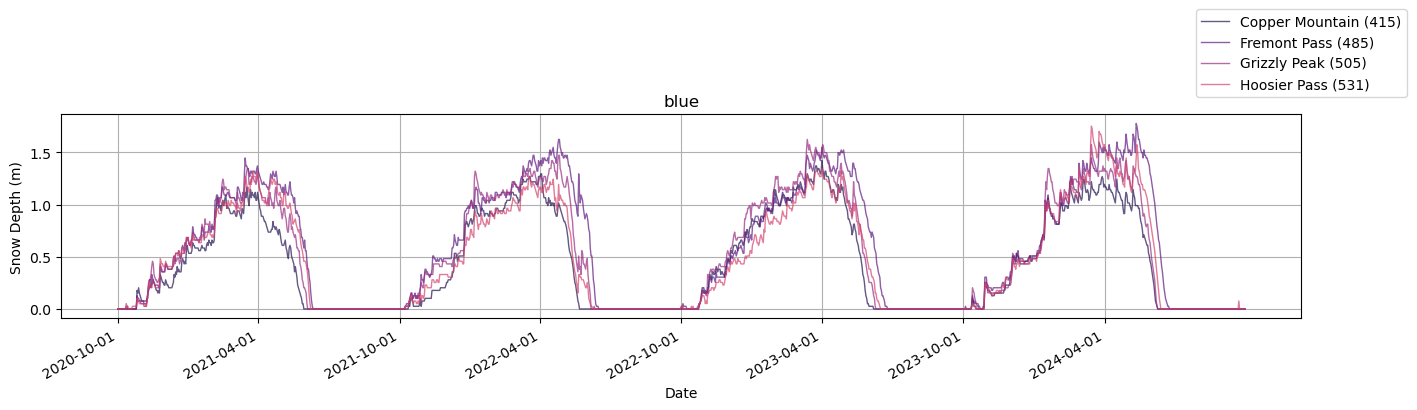

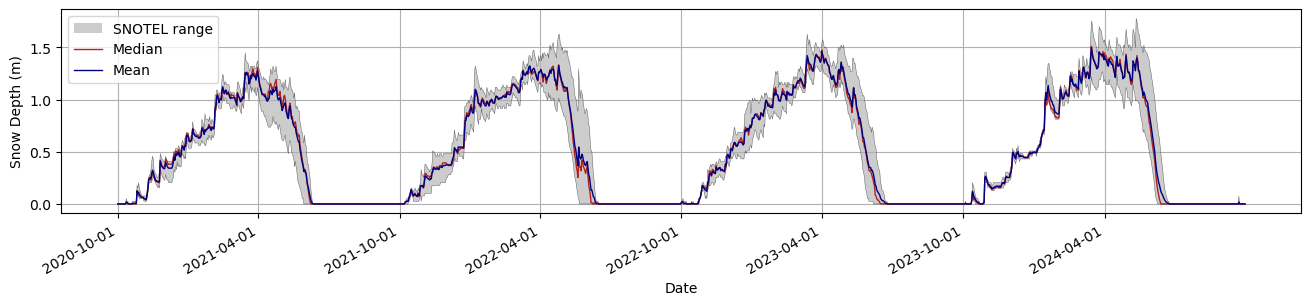

In [10]:
basin = 'blue'
_, snotel_dfs, _ = get_basin_snotel_ts(basin, WY_list, allsites_fn, script_dir)
snotel_megadf, snowdepth_cols, combined = prep_basin_snotel_ts(snotel_dfs)
plot_indiv_basin_snotel_ts(basin, snotel_megadf, snowdepth_cols, combined)
plot_summary_basin_snotel_ts(snotel_megadf, combined)

/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/animas_setup/polys/animas_basin_outline_HUC10_32613.shp
148           Cascade #2 (387)
199        Mineral Creek (629)
200           Molas Lake (632)
213    Red Mountain Pass (713)
225        Spud Mountain (780)
Name: site_name, dtype: object


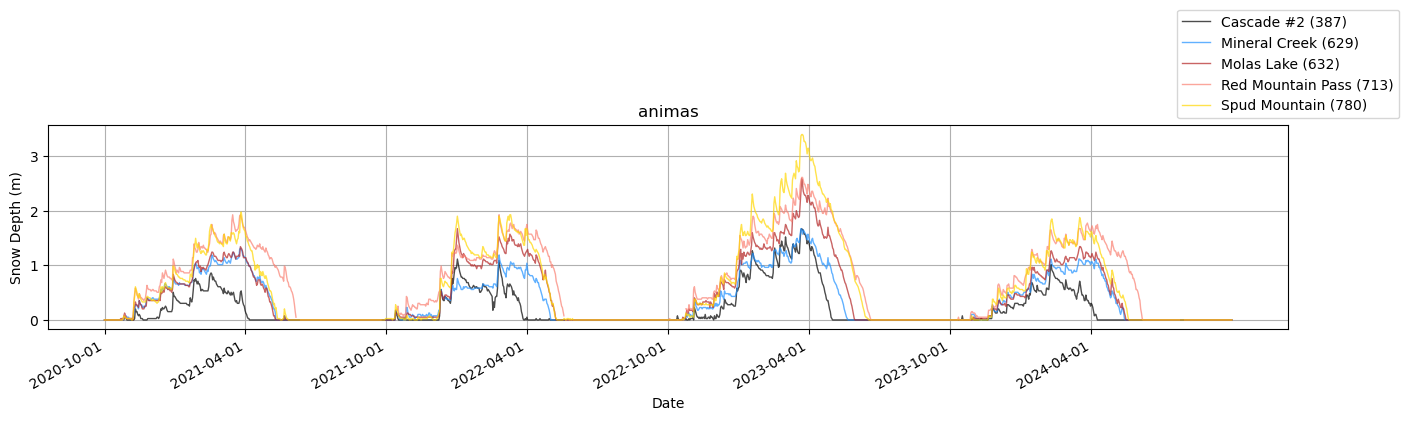

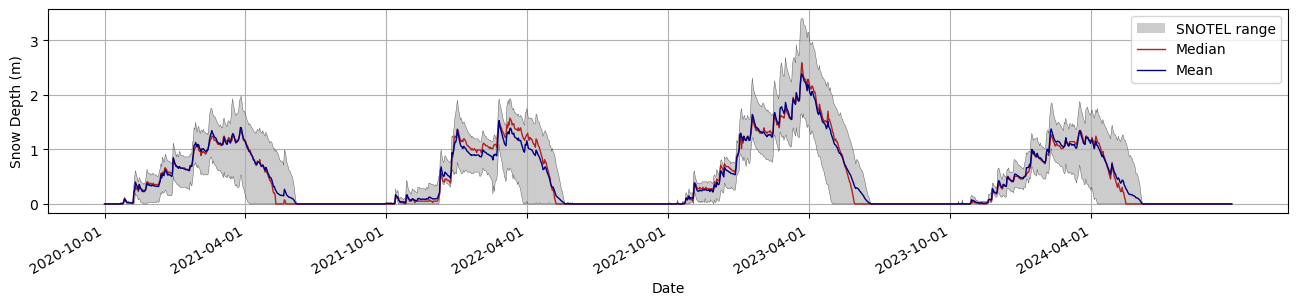

In [11]:
basin = 'animas'
_, snotel_dfs, _ = get_basin_snotel_ts(basin, WY_list, allsites_fn, script_dir)
snotel_megadf, snowdepth_cols, combined = prep_basin_snotel_ts(snotel_dfs)
plot_indiv_basin_snotel_ts(basin, snotel_megadf, snowdepth_cols, combined, colors=['k', 'dodgerblue', 'firebrick', 'salmon', 'gold'])
plot_summary_basin_snotel_ts(snotel_megadf, combined)

/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/yampa_setup/polys/upper_yampa_basin_outline_32613.shp
136        Bear River (1061)
145       Buffalo Park (913)
156             Crosho (426)
160           Dry Lake (457)
163          Elk River (467)
164    Elkhead Divide (1252)
188           Lost Dog (940)
211        Rabbit Ears (709)
214       Ripple Creek (717)
229              Tower (825)
Name: site_name, dtype: object


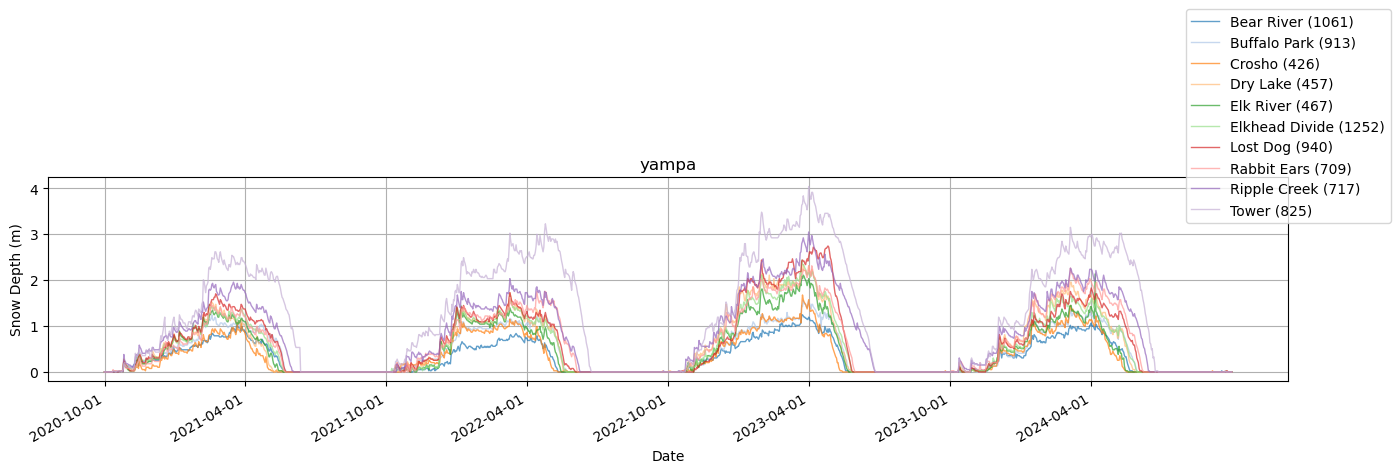

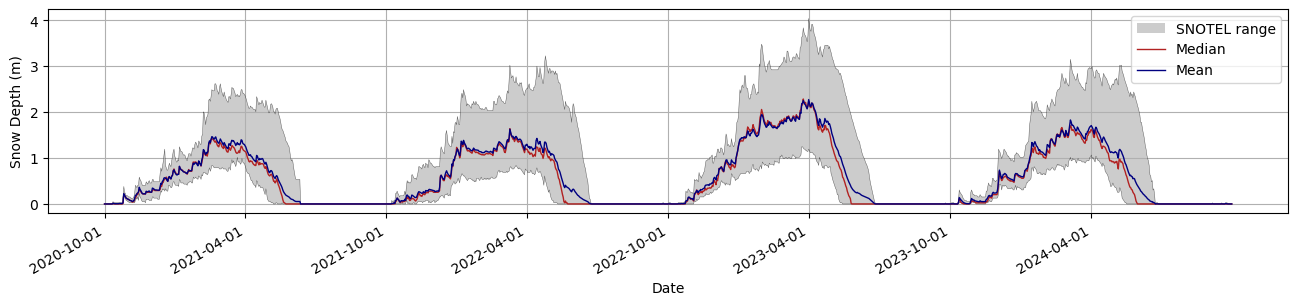

In [12]:
basin = 'yampa'
_, snotel_dfs, _ = get_basin_snotel_ts(basin, WY_list, allsites_fn, script_dir)
snotel_megadf, snowdepth_cols, combined = prep_basin_snotel_ts(snotel_dfs)
plot_indiv_basin_snotel_ts(basin, snotel_megadf, snowdepth_cols, combined, colors=sns.palettes.color_palette('tab20', n_colors=len(snotel_dfs)))
plot_summary_basin_snotel_ts(snotel_megadf, combined)

In [ ]:
def plot_summary_basin_snotel_ts(snotel_megadf, combined, linewidth=1, snotelcolor='k', alpha = 0.2):
    _, ax = plt.subplots(figsize=(16, 3))
    snotel_megadf.min(axis=1).plot(ax=ax, legend=False,
                                    # linewidth=0,
                                    linewidth=linewidth/3,
                                    color=snotelcolor, marker='.', markersize=0, #markersize=3,
                                    alpha=alpha*3
                                    )

    snotel_megadf.max(axis=1).plot(ax=ax, legend=False,
                                    # linewidth=0,
                                    linewidth=linewidth/3,
                                    color=snotelcolor, marker='.', markersize=0, #markersize=3,
                                    alpha=alpha*3
                                    )

    ax.fill_between(snotel_megadf.index,
                    snotel_megadf.min(axis=1),
                    snotel_megadf.max(axis=1), facecolor=snotelcolor, label='SNOTEL range',
                    alpha=alpha)

    snotel_megadf.median(axis=1).plot(ax=ax,
                                    linewidth=linewidth,
                                    color='firebrick', marker='.', markersize=0, #markersize=3,
                                    label='Median'
                                    )

    snotel_megadf.mean(axis=1).plot(ax=ax,
                                    linewidth=linewidth,
                                    color='navy', marker='.', markersize=0, #markersize=3,
                                    label='Mean'
                                    )
    # TODO: Add annotations for the following:
    # the mean of each year's peak snow depth for the time period 
    # the disappearance date of the median time series
    # the range in disappearance dates for all snotel sites each year
    # the range in peak snow depth for all snotel sites each year

    # set xticks for indices of choice (Oct 1 and Apr 1)
    ax.set_xticks(combined)
    ax.set_ylabel('Snow Depth (m)')
    ax.set_xlabel('Date')
    ax.grid()
    ax.legend();

plot_summary_basin_snotel_ts(snotel_megadf, combined)